# **DATA EXPLORATION OF VARIABLE STIFFNESS CYLINDRICAL SHELLS**

Let's start by importing the fundamental libraries for data analysis

In [1]:
import pandas as pd
import numpy as np
import time
import os
import sys
import re

import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.sans-family":'DejaVu Sans',"font.size":8,"axes.titlesize":24,"axes.labelsize":24})   
# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

Now we have to import the input and output data. We start by looking at the compact model information contained in the *model_info.csv* file. This file contains the most relevant parameters of the model that we have defined.

In [11]:
angles_fct = 'linear'
directory = '../metamodel/' + angles_fct + '/'
model_info = pd.read_csv(directory + 'model_info.csv', sep=",")
model_info.index = ['Value']
eff_plies = int(model_info['EffectivePlies'].values)  # free plies
train_smp = int(model_info['Train'].values  # training samples
model_info.head()

,Height,Radius,MaxCurvature,MeshSize,Plies,EffectivePlies,Symmetric,Balanced,AnglesFunction,Train,Test
Value,700,300,0.001575,10,8,4,True,False,linear,218,55


In [15]:
# Load the data
data = pd.read_csv(directory + 'data.csv', sep=",", skiprows=0)
data.index = ['sample' + str(i) for i in range(1, len(data)+1)]
data.describe()

,T0_1,T1_1,T2_1,T0_2,T1_2,T2_2,T0_3,T1_3,T2_3,T0_4,T1_4,T2_4,Buckling,Stiffness
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,2.730000e+02
mean,0.016420,0.538910,-0.168614,0.019393,-0.209703,0.311404,0.001996,0.702399,-0.117100,0.016031,0.722957,0.274779,-832.653736,4.732771e+06
std,26.006252,32.254337,22.488397,26.024167,31.338718,22.491771,26.006003,31.704641,22.777944,26.001355,32.969938,22.307711,15803.061597,1.414169e+06
min,-44.600800,-78.681200,-44.598400,-44.908400,-73.667800,-44.914700,-44.631400,-84.248000,-44.341500,-44.968500,-75.330600,-43.429600,-28443.400000,2.282159e+06
25%,-22.570900,-17.805300,-19.143200,-22.114400,-19.525600,-18.162500,-22.313600,-17.926100,-19.397600,-22.323900,-20.498300,-18.463900,-14836.100000,3.585709e+06
50%,-0.287000,1.416300,0.024000,-0.025500,-1.290700,-0.708000,-0.250900,0.958300,0.387300,-0.139300,-1.327500,0.555400,-11206.500000,4.493416e+06
75%,22.626800,17.583700,18.425200,22.598700,20.185900,18.884700,22.348900,17.525100,17.251700,22.534500,23.534300,18.366700,14013.600000,5.667842e+06
max,44.617000,79.990600,44.327100,44.928000,80.845100,43.865000,44.920600,82.343400,44.185500,44.940400,79.758800,43.086500,28370.400000,9.323844e+06


We can start by looking at the correlation map between all the input feaures and the outputs.

(14.0, 0.0)

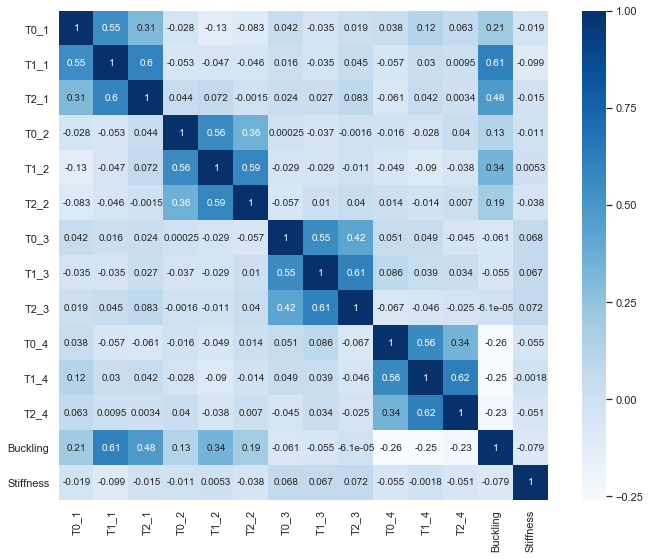

In [18]:
corrmat = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corrmat, square=True, cmap="Blues", annot=True);

# these lines are here only to correct a matplotlib bug
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

We can also visualize correlations by using clustermaps on them.

<Figure size 864x648 with 0 Axes>

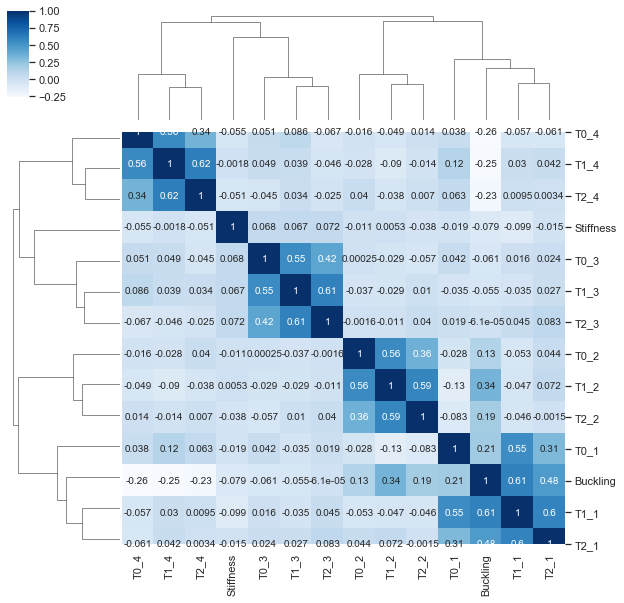

In [27]:
corrmat = data.corr()
plt.figure(figsize=(12,9))
sns.clustermap(corrmat, square=True, cmap="Blues", annot=True);

Let's try to find some pattern between the inputs and the buckling load

In [35]:
data_bck = data.drop('Stiffness', axis=1)

We can divide the buckling in 8 levels: 4 for the positive values and 4 for the negative ones. Then, we can see how are distributed the values of the variables inside these ranges. The levels in the middle will be empty since they correspond to almost null buckling values.

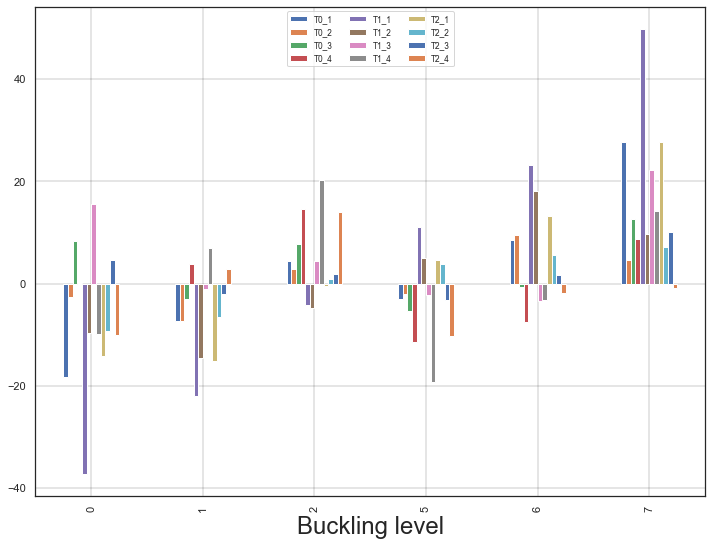

In [79]:
norm_bck = (data_bck['Buckling'] - min(data_bck['Buckling'])) / (max(data_bck['Buckling']) - min(data_bck['Buckling']))
data_bck['LevBuckling'] = [0 if x < 0.125 else 1 if x < 0.25 else 2 if x < 0.375 else 3 if x < 0.5
                          else 4 if x < 0.625 else 5 if x < 0.75 else 6 if x < 0.875 else 7 for x in norm_bck]
data_lvl = data_bck.drop('Buckling', axis=1).groupby(['LevBuckling']).mean()  # group by buckling levels and features mean
data_lvl = data_lvl.reindex(sorted(data_lvl.columns), axis=1)
data_lvl.plot(kind='bar', figsize=(12,9))
plt.grid(color='black', linestyle='-', linewidth=.2)
plt.xlabel('Buckling level')
plt.legend(loc='upper center', fontsize='small', ncol=3)

Let's look at how many samples are present in each of the buckling level group

In [81]:
data_bck['LevBuckling'].value_counts().sort_index()

0    11
1    76
2    55
5    67
6    55
7     9
Name: LevBuckling, dtype: int64

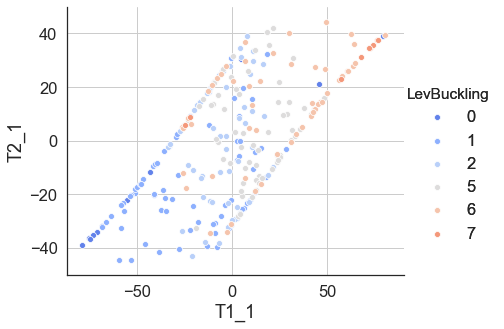

In [93]:
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':2.5})
sns.set_palette("coolwarm", 7)
sns.pairplot(data_bck.drop('Buckling', axis=1), x_vars=['T1_1'], y_vars=['T2_1'], hue='LevBuckling', size=5).add_legend()
plt.grid()

We can also visualize the distribution of the levels for each class. Below we will consider the distribution on the same variables of the previous plot.

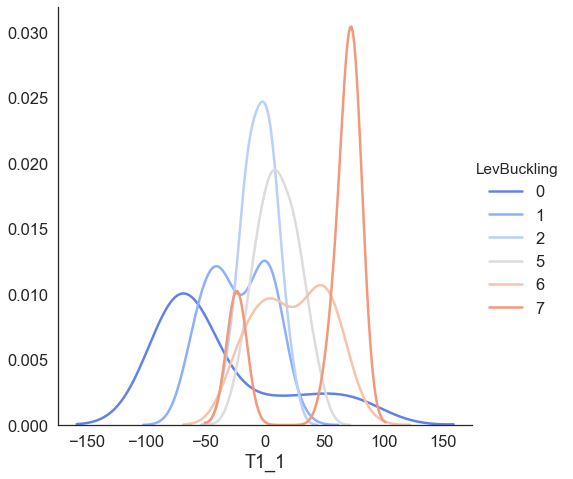

In [107]:
g = sns.FacetGrid(data_bck, hue='LevBuckling', size=7)
g.map(sns.kdeplot, 'T1_1')
g.add_legend()

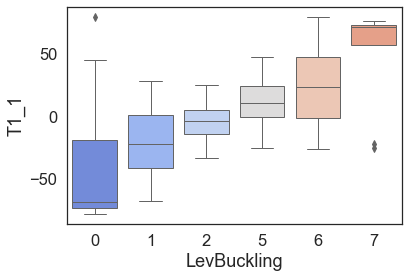

In [113]:
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 1})
sns.boxplot(x='LevBuckling', y='T1_1', data=data_bck.drop('Buckling', axis=1))

We can also visualize the same plot together with the distributions of the samples.

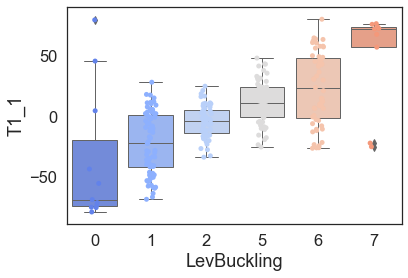

In [118]:
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 1})
g = sns.boxplot(x='LevBuckling', y='T1_1', data=data_bck.drop('Buckling', axis=1))
g = sns.stripplot(x='LevBuckling', y='T1_1', data=data_bck.drop('Buckling', axis=1), jitter=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013A0BCA9088>,
      dtype=object)

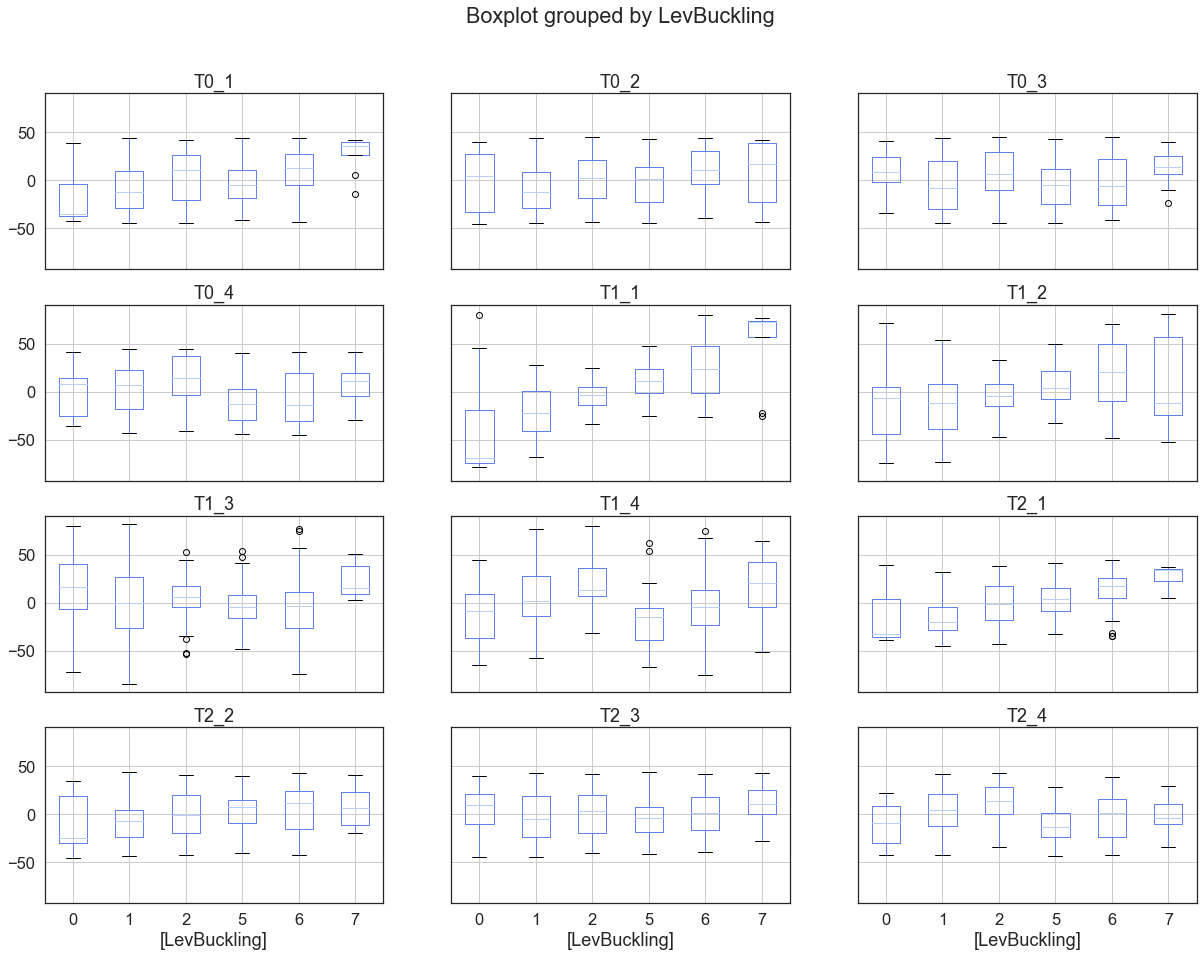

In [112]:
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 1})
data_bck.drop('Buckling', axis=1).boxplot(by='LevBuckling', figsize=(20, 15))

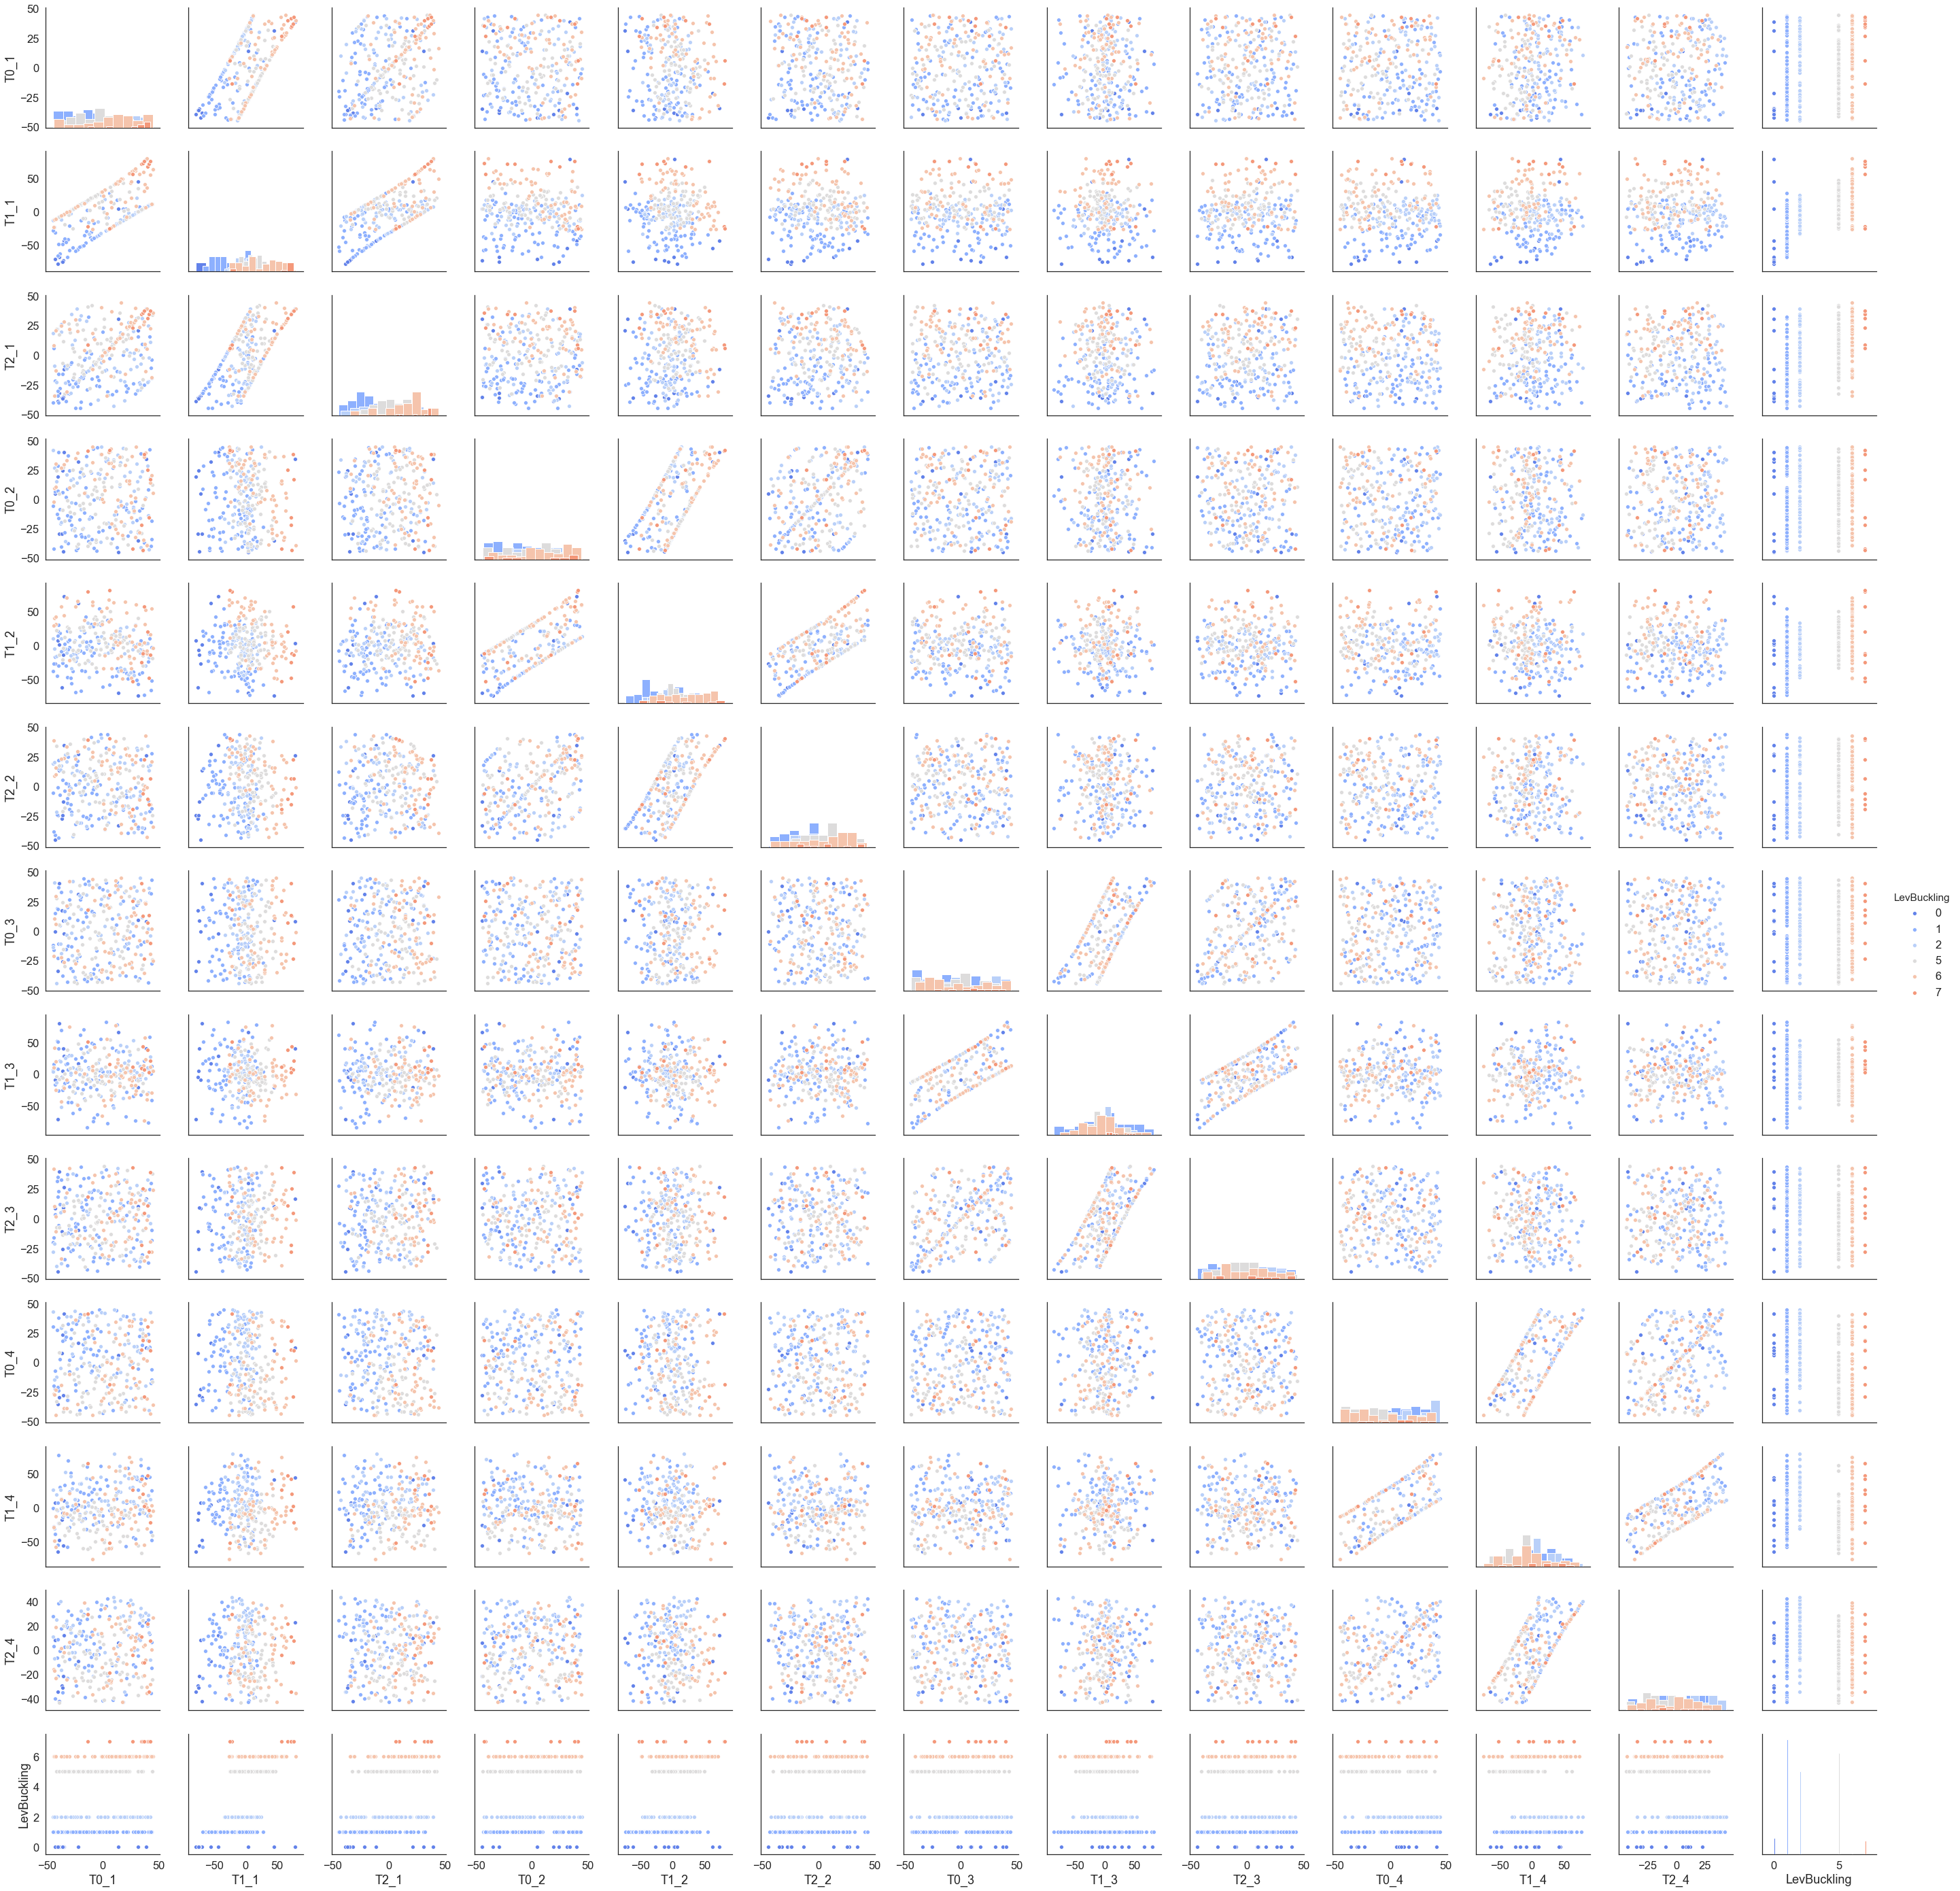

In [121]:
sns.pairplot(data_bck.drop(['Buckling'], axis=1), hue='LevBuckling', size=3, diag_kind='hist')